In [477]:
import heapq
import numpy as np
from typing import Optional, List, Tuple
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from collections import namedtuple


np.__version__

'2.1.3'

In [478]:


class Maze:
    """2D Gridworld Maze Game
    0: Empty cell
    1: Obstacle
    2: Agent's current position
    3: Target position
    """

    State = namedtuple('State', ['x', 'y', 'steps_left', 'reward'])

    def __init__(self, width: int, height: int, seed: Optional[int] = None, cell_occupancy_prob: float = 0.3):
        assert 0 < cell_occupancy_prob < 1, "Cell occupancy probability must be in the range (0, 1)"
        assert width > 2 and height > 2, "Width and height must be greater than 2"

        self.width = width
        self.height = height
        self.seed = seed
        self.cell_occupancy_prob = cell_occupancy_prob
        self.generate_map()

        self.action_size = 5  # Up, Down, Left, Right, Stay

    def get_initial_state(self) -> State:
        return Maze.State(self.source[0], self.source[1], self.max_steps, 0)
    
    def get_next_state(self, state: State, action):
        dx, dy = self.action_to_delta(action)
        # Additional reward is -1 for each x or y coordinate moved.
        dr = (abs(dx) + abs(dy)) * -1
        if (state.x, state.y) == self.target:
            dr += 300
        elif state.steps_left == 1:
            dr += -100
        return Maze.State(state.x + dx, state.y + dy, state.steps_left - 1, state.reward + dr)
    
    def get_valid_moves(self, state: State):
        valid_moves = []
        for action in range(self.action_size):
            dx, dy = self.action_to_delta(action)
            nx, ny = state.x + dx, state.y + dy
            if self.map[nx, ny] != 1:
                valid_moves.append(action)
        return valid_moves
    
    def get_value_and_terminated(self, state: State):
        if (state.x, state.y) == self.target or state.steps_left == 0:
            return state.reward, True
    
        return state.reward, False
    
    def action_to_delta(self, action):
        action_to_delta = [(0, 1), (0, -1), (-1, 0), (1, 0), (0, 0)]  # Up, Down, Left, Right, Stay
        return action_to_delta[action]
    
    def generate_map(self):
        if self.seed is not None:
            np.random.seed(self.seed)
        count = 0
        while True:
            count += 1
            map = np.random.choice([0, 1], size=(self.width, self.height), p=[1-self.cell_occupancy_prob, self.cell_occupancy_prob])
            # Make the boundaries of the maze walls
            map[0, :] = 1
            map[-1, :] = 1
            map[:, 0] = 1
            map[:, -1] = 1

            # Randomly select two unique non-border positions for the source and target
            while True:
                # Generate two random positions within the non-border range
                source = (np.random.randint(1, self.width - 1), np.random.randint(1, self.height - 1))
                target = (np.random.randint(1, self.width - 1), np.random.randint(1, self.height - 1))
                
                # Ensure the positions are unique
                if source != target:
                    break
            
            # Make sure the source and target do not have obstacles
            map[source] = 2
            map[target] = 3

            self.source = source
            self.target = target

            # Set the max steps to be 3 * the L1 distance between source and target
            self.max_steps = 3 * (abs(source[0] - target[0]) + abs(source[1] - target[1]))

            self.map = map
            astar = AStar(self)
            success, self.shortest_path = astar.solve()
            if success:
                break
            print(f"Unsolvable maze {count}. Regenerating...")

    def visualize_shortest_path(self):
        map = self.map.copy()
        truncated_path = self.shortest_path[1:-1]  # Exclude source and target
        for pos in truncated_path:
            map[pos] = 4
        self.visualize_state(map)

    def visualize_state(self, map: Optional[np.ndarray] = None):
        if map is None:
            map = self.map
        # Define colors for each type of cell
        cmap = mcolors.ListedColormap(['white', 'black', 'red', 'green', 'cyan'])
        
        # Plot the maze using imshow
        plt.imshow(map, cmap=cmap)
        plt.axis('off')  # Hide axes
        plt.show()

class AStar:
    def __init__(self, maze: Maze):
        self.maze = maze
        self.start = maze.source
        self.goal = maze.target
        self.height, self.width = maze.height, maze.width

    def heuristic(self, a: Tuple[int, int], b: Tuple[int, int]) -> int:
        # Manhattan distance
        return abs(a[0] - b[0]) + abs(a[1] - b[1])

    def successors(self, pos: Tuple[int, int]) -> List[Tuple[int, int]]:
        x, y = pos
        successors = []
        directions = [(0, 1),(0, -1), (-1, 0), (1, 0)]  # Up, Down, Left, Right
        for dx, dy in directions:
            nx, ny = x + dx, y + dy
            if self.maze.map[nx, ny] != 1:
                successors.append((nx, ny))
        return successors

    def solve(self) -> bool:
        open = []
        heapq.heappush(open, (0, self.start))
        came_from = {}
        g_score = {self.start: 0}

        while open:
            _, current = heapq.heappop(open)
            
            if current == self.goal:
                path = [current]
                while current in came_from:
                    current = came_from[current]
                    path.append(current)
                path.reverse()
                return True, path  # Maze is solvable

            for successor in self.successors(current):
                tentative_g_score = g_score[current] + 1
                if successor not in g_score or tentative_g_score < g_score[successor]:
                    came_from[successor] = current
                    g_score[successor] = tentative_g_score
                    f_score = tentative_g_score + self.heuristic(successor, self.goal)
                    heapq.heappush(open, (f_score, successor))

        return False, []  # Maze is not solvable

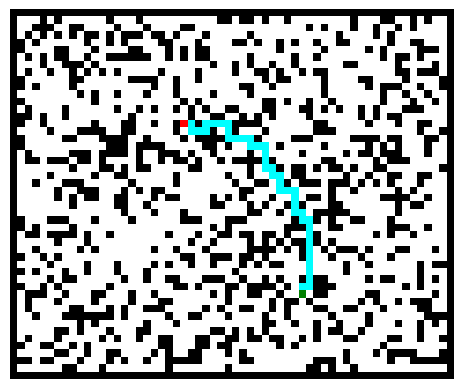

In [503]:
maze = Maze(50, 60)
maze.visualize_shortest_path()